In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns


: 

**Import** **Dataset**

In [ ]:
dataset = pd.read_csv('PDFMalware2022.csv')
# Xoá cột fine name, inplace = True dùng để gán trực tiếp lại cho biến data không cần sử dụng toán tử gán
# axis=1 thể hiện thực hiện trên cột, axis=0 thực hiện trên dòng
dataset.drop(["Fine name"], axis=1, inplace=True)

dataset

: 

**Đếm thuộc tính "Malicious" trên "Class"**

In [ ]:
b = dataset['Class']
malicious_count = b[b == 'Malicious'].count()
malicious_count

: 

In [ ]:
dataset.dtypes

: 

**Preproccessing**

In [ ]:
# Input vào model chỉ có số, mà trong data ở trên có những cột có cả text (những cột này python định nghĩa dạng dữ liệu object, vì vậy cần chuyển về dạng dữ liệu số)
# Ordinal encoder thực hiện việc chuyển đổi data từ dạng khác (object, string,...) về dạng số. Ví dụ ["text1", "hi", "an com chua", "helu"] -> [0, 1, 2, 3]

# Import thư viện, hàm Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder

# Lọc ra những cột có thuộc tính là object từ dataframe (dataframe là cái biến dataset á), sau đó gán mảng chứa tên các thuộc tính là object vào biến tên là "object columns"
# Từ cell dataset.dtypes phía trên thì có thể thấy được chỉ có object và float, vì vậy không cần lo là nó có các dạng khác như string
# Thật ra object là dạng dữ liệu tổng quát nhất của python, nên trong object cũng có string rồi
object_columns = dataset.select_dtypes(include=['object']).columns

: 

In [ ]:
dataset[object_columns]

: 

In [ ]:
# Khai báo biến encoder 
encoder = OrdinalEncoder()

# Tiến hành fit và transform các cột có dạng dữ liệu là object trong dataframe
dataset[object_columns] = encoder.fit_transform(dataset[object_columns])

# Có thể viết tách ra như sau
# encoder.fit(dataset[object_columns])
# dataset[object_columns] = encoder.transform(dataset[object_columns])

: 

In [ ]:
# Check số lượng dòng bị khuyết của mỗi cột
# Giúp có cái nhìn tổng quan về phạm vi và mức độ của dữ liệu bị thiếu trong DataFrame
dataset.isna().sum()

: 

In [ ]:
# Sau khi xử lí có vài giá trị khuyết, vì vậy bỏ những cột bị khuyết giá trị bằng câu lệnh sau
# Làm như thế nào để check thì 
dataset.dropna(inplace=True)
dataset.isna().sum()

: 

In [ ]:
y = dataset['Class']
X = dataset.drop(['Class'], axis =1)

: 

In [ ]:
# Chuyển dữ liệu về int
# Vì đây là mô hình phân loại nên sẽ để hai biến độc lập, còn float thì máy có thể hiểu nó là hai biến liên tục
# 1.0 đến 2.0 là liên tục nè, còn 1 với 2 là độc lập. Hoặc "1" với "2" (string) cũng là độc lập
# Bước này làm cho chắc thoi
y = y.astype(int)

: 

In [ ]:
# Vẽ biểu đồ số lượng nhãn của cột target, biểu đồ cột-bar chart

c = pd.DataFrame(data=y)
c.Class.value_counts().plot(kind='bar', title='Data Imbalance');
print(dataset['Class'].value_counts())

: 

**SMOTE**
(**Random** **Over** **Sampler**)

In [ ]:
# MinMax Scaler chuẩn hóa giá trị từ 0-1 => đồng nhất, dễ quản lý, cải thiện hiệu suất, máy đọc từ 0->1
# Ngoài ra còn có StandardScaler chuẩn hoá giá trị về phạm vi -1, 1 (đôi lúc có thể ngoài xíu)
# Khác nhau chỗ nào thì tìm hiểu, cũng dễ á

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
# Đưa dữ liệu cho mô hình học
mm.fit(X)

# Chuyển đổi dữ liệu sau khi mô hình đã học
X_mm = mm.transform(X)
# X_mm =mm.fit_transform(X)

: 

Random Oversampling: Randomly duplicate examples in the minority class. (1: 900; 0: 100 -> 1: 900; 0: 900)

Random Undersampling: Randomly delete examples in the majority class.(1: 900; 0: 100 -> 1: 100; 0: 100)

In [ ]:
# Cân bằng dữ liệu, lấy duplicate mẫu trong class ít để cho nhiều lên bằng class còn lại

OverSampler = RandomOverSampler(random_state=0, sampling_strategy='auto')
X_resample, y_resample = OverSampler.fit_resample(X,y)

: 

In [ ]:
X_mm

: 

In [ ]:
# Khúc này code có sẵn print ra để xem thôi chứ không có gì, bỏ cell này cũng được cho đỡ rối
conv = pd.DataFrame(X_mm,columns=  X.columns)

conv

: 

**Import Library SMOTE**

In [ ]:
# Cũng là phương pháp cân bằng dữ liệu khác, tạo sinh dữ liệu của lớp ít cho bằng với lớp nhiều 
# (tự tạo thêm điểm dữ liệu từ những điểm dữ liệu có sẵn, thuật toán tự tìm hiểu thêm, cũng dễ hiểu)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X_mm, y)

: 

In [ ]:
c = pd.DataFrame(data=y_smote,columns=["Class"])
c.Class.value_counts().plot(kind='bar', title='Data Balance');
print (c.value_counts())

: 

In [ ]:
X_smote

: 

In [ ]:
y_smote

: 

**Parameter use GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Tạo một biến lưu mô hình Decision Tree
model = DecisionTreeClassifier()

# Sử dụng GridSearchCV để dò tìm bộ tham số tốt nhắt
parameters = {
        'max_depth' : [1,2,3,4,5,7,8,9,10],
        'criterion' : ["gini", "entropy"], # xác định tiêu chí để chọn cách phân chia tốt nhất cho mỗi node trong cây
        'min_samples_leaf': [1,2,3,4,5], # min_samples_leaf đảm bảo số lượng mẫu tối thiểu trong một lá
        'min_samples_split': [2,3,4,5] # Tham số min_samples_split sẽ đánh giá số lượng mẫu trong nút và 
                                        #nếu số lượng nhỏ hơn mức tối thiểu 
                                        #thì sẽ tránh được sự phân tách và nút sẽ là một chiếc lá.
}

: 

In [ ]:
# Chia fold trong khi training
search = GridSearchCV(model,
                      parameters,
                      cv = 5, # chia làm 5 fold
                      verbose = 3
                      )
search.fit(X_smote, y_smote)

: 

In [ ]:
# Đây là điểm cao nhất tương ứng với bộ param phía trên
search.best_score_, search.best_params_

: 

**Stratified K-Fold Cross Validation**

#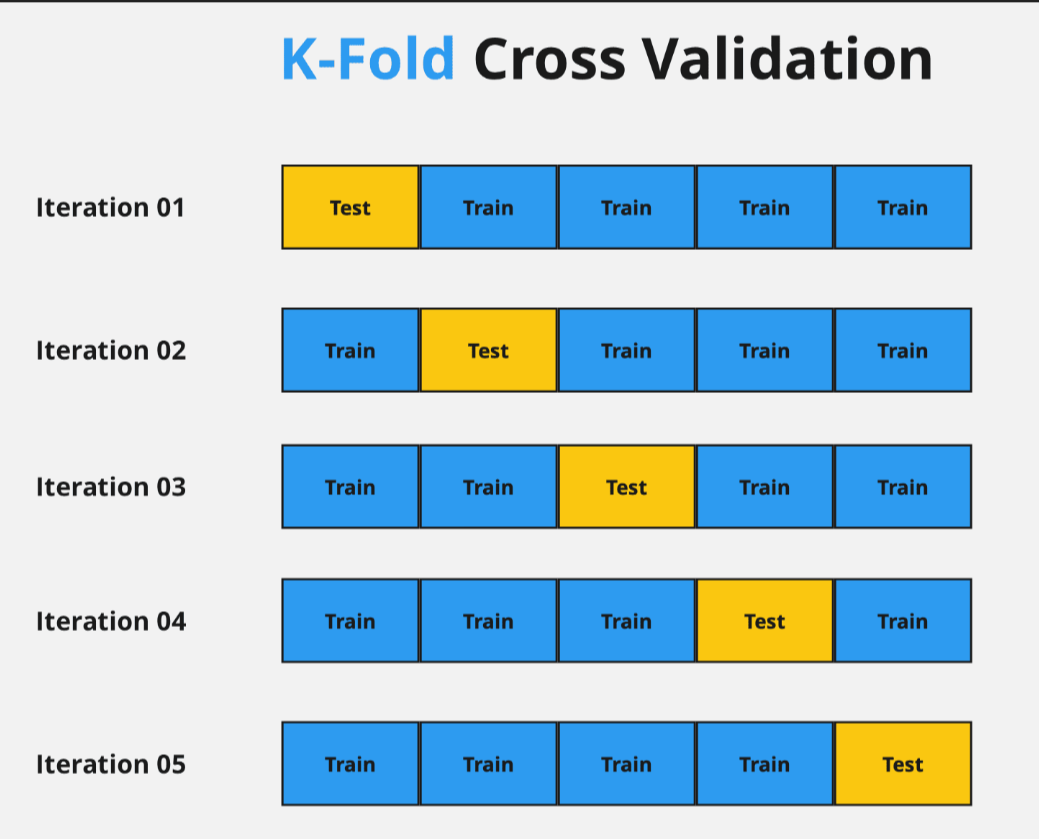


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Định nghĩ KFold (KFold dùng để chia dữ liệu thành nhiều khối nhỏ, đảm bảo dữ tính tổng quát khi đánh giá dữ liệu)
skf = StratifiedKFold(n_splits=5)
score_skf = []
cm_skf = []

: 

In [ ]:
# Định nghĩ mô hình Decision tree cho KFold với bộ tham số tốt nhất phía trên
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(criterion= search.best_params_["criterion"],
                            max_depth= search.best_params_["max_depth"],
                            min_samples_leaf= search.best_params_["min_samples_leaf"],
                            min_samples_split= search.best_params_["min_samples_split"]
                            )


: 

In [ ]:
# Tính điểm cho từng fold trong K-Fold
i=1
for train_set, test_set in skf.split(X_smote, y_smote):
  tree.fit(X_smote[train_set], y_smote[train_set])
  sco = tree.score(X_smote[test_set], y_smote[test_set])
  score_skf.append(sco)
  y_pred=tree.predict(X_smote[test_set])
  cm=confusion_matrix(y_smote[test_set], y_pred)
  cm_skf.append(cm)
  print("iteration ", i)
  i +=1

: 

In [ ]:
score_skf

: 

In [ ]:
cm_skf

: 

: 